<a href="https://colab.research.google.com/github/routhleck/jax-md/blob/main/examples-with-unit/1-Minimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import & Util

# %%capture

!pip install git+https://github.com/routhleck/jax-md.git
!pip install brainunit
!pip install brainstate

import jax.numpy as np
from jax import device_put
from jax import config
# TODO: Uncomment this and enable warnings when XLA bug is fixed.
import warnings; warnings.simplefilter('ignore')
config.update('jax_enable_x64', True)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
warnings.simplefilter("ignore")

sns.set_style(style='white')
background_color = [56 / 256] * 3
def plot(x, y, *args):
  plt.plot(x, y, *args, linewidth=3)
  plt.gca().set_facecolor([1, 1, 1])
def draw(R, **kwargs):
  if 'c' not in kwargs:
    kwargs['color'] = [1, 1, 0.9]
  ax = plt.axes(xlim=(0, float(jnp.max(R[:, 0]))),
                ylim=(0, float(jnp.max(R[:, 1]))))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_facecolor(background_color)
  plt.scatter(R[:, 0], R[:, 1],  marker='o', s=1024, **kwargs)
  plt.gcf().patch.set_facecolor(background_color)
  plt.gcf().set_size_inches(6, 6)
  plt.tight_layout()
def draw_big(R, **kwargs):
  if 'c' not in kwargs:
    kwargs['color'] = [1, 1, 0.9]
  fig = plt.figure(dpi=128)
  ax = plt.axes(xlim=(0, float(jnp.max(R[:, 0]))),
                ylim=(0, float(jnp.max(R[:, 1]))))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_facecolor(background_color)
  s = plt.scatter(R[:, 0], R[:, 1], marker='o', s=0.5, **kwargs)
  s.set_rasterized(True)
  plt.gcf().patch.set_facecolor(background_color)
  plt.gcf().set_size_inches(10, 10)
  plt.tight_layout()
def draw_displacement(R, dR):
  plt.quiver(R[:, 0], R[:, 1], dR[:, 0], dR[:, 1], color=[1, 0.5, 0.5])

# Progress Bars

from IPython.display import HTML, display
import time

def ProgressIter(iter_fun, iter_len=0):
  if not iter_len:
    iter_len = len(iter_fun)
  out = display(progress(0, iter_len), display_id=True)
  for i, it in enumerate(iter_fun):
    yield it
    out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# 1-Minimization

## Energy and Automatic Differentiation

$$
u(r) = \begin{cases}\frac13(1 - r)^3 & \text{if $r < 1$} \\ 0 & \text{otherwise} \end{cases}
$$

In [2]:
import jax.numpy as jnp
import brainunit as u
import brainstate as bst

@u.assign_units(r=u.angstrom, result=u.eV)
def soft_sphere(r):
  return jnp.where(r < 1,
                   1/3 * (1 - r) ** 3,
                   0.)

print(soft_sphere(0.5 * u.angstrom))

0.04166667 * electronvolt


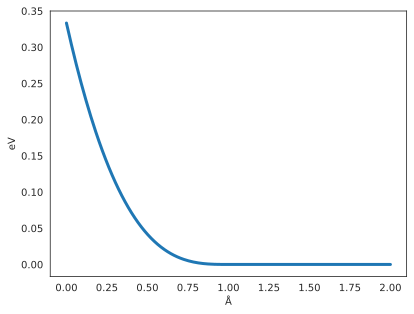

In [3]:
r = u.math.linspace(0 * u.angstrom, 2. * u.angstrom, 200)
plot(r, soft_sphere(r))

We can compute its derivative automatically

In [4]:
from brainunit.autograd import grad

du_dr = grad(soft_sphere)

print(du_dr(0.5 * u.angstrom))

-0.25 * intermolecular force


We can vectorize the derivative computation over many radii

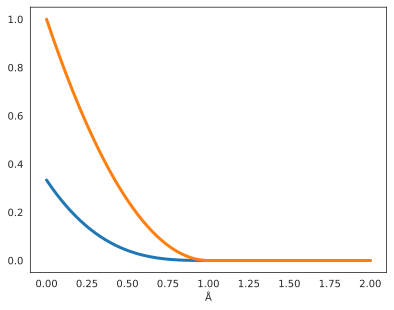

In [5]:
from jax import vmap

du_dr_v = vmap(du_dr)

plot(r, soft_sphere(r).mantissa)
plot(r, -du_dr_v(r).mantissa)

### Randomly Initialize a System

In [6]:
from jax import random

key = random.PRNGKey(1)

particle_count = 128
number_density = 1.2 / u.angstrom ** 2
dim = 2

In [7]:
from jax_md import quantity

# number_density = N / V
box_size = quantity.box_size_at_number_density(particle_count = particle_count,
                                               number_density = number_density,
                                               spatial_dimension = dim)

R = bst.random._random_for_unit.uniform_for_unit(key, (particle_count, dim), minval=0*u.angstrom, maxval=box_size)

In [8]:
from jax_md.colab_tools import renderer
renderer.render(box_size, renderer.Disk(R), resolution=(512, 512))

## Displacements and Distances


In [9]:
from jax_md import space

displacement, shift = space.periodic(box_size)

print(displacement(R[0], R[1]))

ArrayImpl([ 2.6709671, -4.09407854], dtype=float32) * angstrom


In [10]:
metric = space.metric(displacement)

print(metric(R[0], R[1]))

4.8883066 * angstrom


Compute distances between pairs of points

In [11]:
v_displacement = space.map_product(displacement)
v_metric = space.map_product(metric)

print(v_metric(R[:3], R[:3]))

ArrayImpl([[0.       , 4.88830709, 4.64909458],
           [4.88830662, 0.       , 4.22363997],
           [4.64909458, 4.22363997, 0.       ]], dtype=float32) * angstrom


## Total Energy of a System

In [12]:
def energy_fn(R):
  dr = v_metric(R, R)
  return 0.5 * u.math.sum(soft_sphere(dr))

In [13]:
print(energy_fn(R))

29.554455 * electronvolt


In [14]:
print(grad(energy_fn)(R).shape)

(128, 2)


## Minimization

In [15]:
from jax_md import minimize

init_fn, apply_fn = minimize.fire_descent(energy_fn, shift)

In [16]:
state = init_fn(R)

trajectory = []

while u.math.max(u.math.abs(state.force)) > 1e-4 * u.IMF:
  state = apply_fn(state)
  trajectory += [state.position]

In [17]:
trajectory = u.math.stack(trajectory)

renderer.render(box_size,
                renderer.Disk(trajectory),
                resolution=(512, 512))